**Importing all the important libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from datasets import load_dataset, Dataset
from sklearn.ensemble import  RandomForestClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from mediapipe_handler import MediaPipeHandler
from get_work_out_labels import add_workout_label_back
import seaborn as sns
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


**Workflow**
1. Loading Training and Testing Datasets
2. Add Label string values
3. Looking at workout distributions
4. Preprocessing
5. Feature Engineering
6. Train Random Forest with hyperparameters [with and without feature engineering]
7. Train Neural Network with hyperparameters [with and without feature engineering]
8. Train SVM with hyperparameters [with and without feature engineering]
9. Compare model performance in terms of SPEED,ACCURACY,PERCISION,RECALL,F1-SCORE
10. Do the same process but with SMOTE to handle imbalance classes, then compare accuracy

**1. Loading Training and Testing Datasets**

In [104]:
mediapipe_model = MediaPipeHandler()

training_dataset=mediapipe_model.read_csv_to_pd("H:\\DesD_AI_pathway\\AI\\data\\train_new.csv")[:40000]
testing_dataset=mediapipe_model.read_csv_to_pd("H:\\DesD_AI_pathway\\AI\\data\\test_new.csv")
validation_dataset=mediapipe_model.read_csv_to_pd("H:\\DesD_AI_pathway\\AI\\data\\validation_new.csv")


In [108]:
training_dataset

,Unnamed: 0,image,label,muscle group,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle,WorkoutLabel
0,0,<PIL.Image.Image image mode=RGB size=480x360 a...,15,6,"[0.58193522, 0.50112382, 0.18629067]","[0.56808483, 0.50764973, -0.39121403]","[0.51472628, 0.62443262, 0.24231351]","[0.49207747, 0.64792533, -0.40445392]","[0.49354789, 0.82472387, 0.04274469]","[0.50626731, 0.7829355, -0.38012081]","[0.43472037, 0.59765159, 0.15821532]","[0.41219012, 0.55765157, -0.18925683]","[0.48681087, 0.77216471, 0.21341489]","[0.53131352, 0.74951092, -0.20592448]","[0.46865928, 0.91335332, 0.28234741]","[0.46019804, 0.9247452, -0.00511335]",romanian deadlift
1,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,5,3,"[0.28851402, 0.34632418, 0.05797124]","[0.04557932, 0.2625281, -0.53252532]","[0.31472653, 0.55251676, 0.20697118]","[0.29954293, 0.70734787, -0.42103916]","[0.38072553, 0.48718524, 0.33211541]","[0.41487545, 0.90066576, -0.34059951]","[0.29769287, 0.73485333, 0.12331318]","[0.29887038, 0.76744193, -0.12280818]","[0.3553625, 0.96489376, 0.29922676]","[0.37855217, 1.00014687, 0.04580913]","[0.33431396, 1.14584696, 0.52574289]","[0.34521011, 1.18565392, 0.29601833]",hammer curl
2,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,2,"[0.55812296, 0.60558632, -0.31862211]","[0.54033719, 0.5194419, 0.03683491]","[0.59000856, 0.39495367, -0.3952117]","[0.57020998, 0.34851226, 0.02088831]","[0.59840808, 0.18992878, -0.43882276]","[0.61205947, 0.14454675, -0.05049171]","[0.2700583, 0.67925573, -0.00451916]","[0.31016475, 0.61177252, 0.09308374]","[0.17301074, 0.78203309, 0.21341456]","[0.19213295, 0.70254374, 0.24907656]","[0.21335692, 0.80375698, 0.24622165]","[0.2225073, 0.77971029, 0.28900969]",bench press
3,3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2,2,"[0.47324845, 0.46224624, -0.36844781]","[0.3944301, 0.42113358, 0.07993262]","[0.35917228, 0.59713042, -0.40773576]","[0.32909209, 0.50818831, 0.13586867]","[0.23465902, 0.57894927, -0.37273002]","[0.22452545, 0.54579496, -0.00402407]","[0.45091149, 0.75847185, -0.11720919]","[0.39312249, 0.72117323, 0.11696515]","[0.34541321, 0.93201154, -0.28890157]","[0.26223892, 0.83523107, -0.04077852]","[0.38439947, 1.03564775, 0.05702363]","[0.2956574, 1.02744222, 0.1358386]",chest fly machine
4,4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21,5,"[0.40535274, 0.32959157, 0.2256517]","[0.50714397, 0.34202528, -0.14267525]","[0.39284018, 0.47519884, 0.25000408]","[0.49911273, 0.51368439, -0.08846831]","[0.42754868, 0.54632509, 0.25755784]","[0.40405584, 0.57879004, 0.0152924]","[0.37856826, 0.62843364, 0.13012259]","[0.43758205, 0.63440937, -0.13035484]","[0.40305325, 0.86229086, 0.14247797]","[0.44339809, 0.88249779, -0.08351019]","[0.39687654, 1.08169973, 0.16671824]","[0.43235433, 1.10711813, -0.06191889]",tricep pushdown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,<PIL.Image.Image image mode=RGB size=480x360 a...,15,6,"[0.49728319, 0.28191486, 0.20924595]","[0.48524806, 0.26911303, -0.24038868]","[0.49389845, 0.3995018, 0.24761593]","[0.49088708, 0.41162705, -0.30106354]","[0.52592897, 0.50540936, 0.16803233]","[0.74968287, 0.25552783, -0.34731376]","[0.60111485, 0.52156282, -0.13698869]","[0.47343642, 0.52337605, -0.13320208]","[0.47640738, 0.71848202, 0.13553892]","[0.48249894, 0.72783816, -0.13334687]","[0.47533014, 0.91003561, 0.18083279]","[0.48115045, 0.93802559, -0.11752477]",romanian deadlift
39996,39996,<PIL.JpegImagePlugin.JpegImageFile image mode=...,16,4,"[0.55641991, 0.56363511, -0.06671584]","[0.47732234, 0.58475238, 0.21537079]","[0.5407576, 0.7031548, -0.13025649]","[0.44216606, 0.69566208, 0.20043488]","[0.46649054, 0.67179126, -0.11923274]","[0.40813902, 0.71041363, 0.01033399]","[0.51133323, 0.84158552, -0.0940787]","[0.45476943, 0.83185428, 0.09399175]","[0.44843072, 0.68392211, -0.27670389]","[0.3737376, 0.67001975, 0.00878284]","

In [109]:
training_dataset['left_ankle']

0         [0.46865928, 0.91335332, 0.28234741]
1         [0.33431396, 1.14584696, 0.52574289]
2         [0.21335692, 0.80375698, 0.24622165]
3         [0.38439947, 1.03564775, 0.05702363]
4         [0.39687654, 1.08169973, 0.16671824]
                         ...                  
39995     [0.47533014, 0.91003561, 0.18083279]
39996    [0.34248239, 0.91527069, -0.36795115]
39997     [0.30243289, 1.03038561, 0.34335852]
39998    [0.29583991, 0.84427339, -0.23214397]
39999     [0.21124816, 0.89931577, 0.60866332]
Name: left_ankle, Length: 40000, dtype: object

**2. Add Label String Values**

In [105]:
training_dataset['WorkoutLabel']=training_dataset.apply(lambda x: add_workout_label_back(x['label']) ,axis=1)

**3. Looking at Workout Distribution**

In [106]:
Workout_labels=training_dataset['WorkoutLabel'].unique()

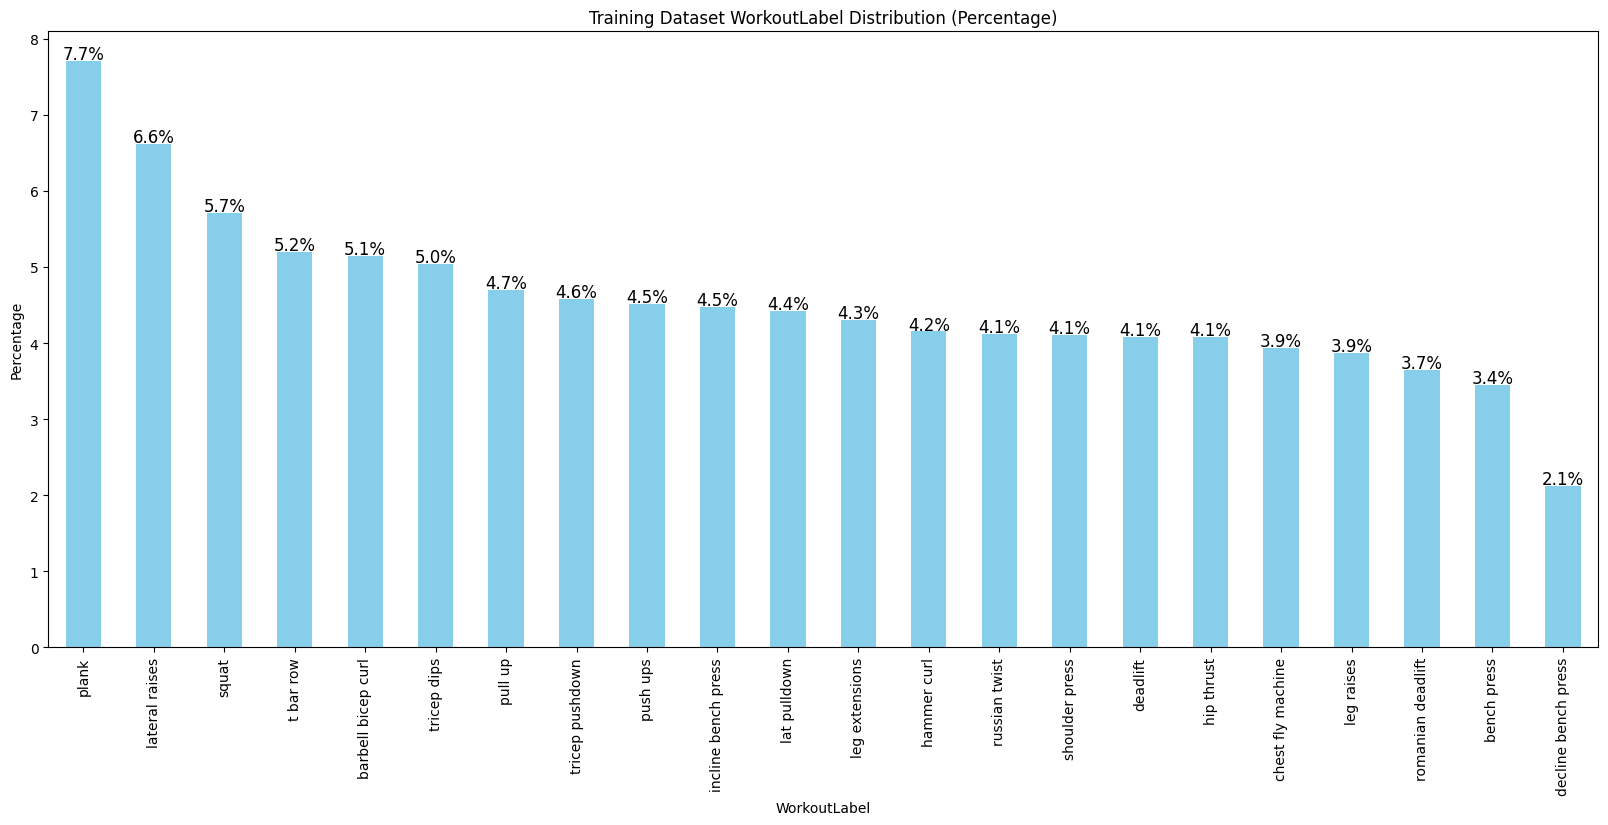

In [107]:
plt.figure(figsize=(20,8))
value_counts = training_dataset['WorkoutLabel'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Plot
ax = percentages.plot(kind='bar', color='skyblue')

# Add percentage text on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Training Dataset WorkoutLabel Distribution (Percentage)')
plt.ylabel('Percentage')
plt.show()

**4. Preprocessing**

**We have to make sure that we get right of Unamed 0: column, as it just contains numerical index not very useful, might lead to overfitting if it is left**
- Get rid of Unnamed 0:
- Get rid of image
- Get rid of muscle group
- split each feature into x,y,z components, then remove that original feature


In [110]:
"""
Removes original feature and splits it into x,y,z components

"""
def Preprocess_data(dataframe,columns_to_flatten):
    final_df=dataframe.copy()
    # Expanding each column into 3 separate columns (x, y, z) and appending it to the final dataframe.
    for column in columns_to_flatten:
        # print(np.vstack(dataframe[column]).astype(float))
        expanded_df=pd.DataFrame(np.vstack(dataframe[column]).astype(float), 
                           columns=[column+'_x', column+'_y', column+'_z'],
                           index=dataframe.index)
        new_df = pd.concat([dataframe.drop(column, axis=1), expanded_df], axis=1)
        for new_column in new_df.columns:
            final_df[new_column] = new_df[new_column]

    return final_df.drop(columns=columns_to_flatten,axis=1)

"""
Splits dataset into X_train,y_train or X_test,y_test, if you give it training dataset then X_train and y_train

"""
def Return_X_y(dataframe,columns_to_delete):
    X=dataframe.drop(columns=columns_to_delete)
    y=dataframe['label']
    return X,y

In [111]:
features_to_split=['left_shoulder',
       'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist',
       'right_wrist', 'left_hip', 'right_hip', 'left_knee',
       'right_knee', 'left_ankle', 'right_ankle']

training_dataset_preprocessed=Preprocess_data(training_dataset,features_to_split)
X_train, y_train = Return_X_y(training_dataset_preprocessed,['label','muscle group','WorkoutLabel','image','Unnamed: 0'])


testing_dataset_preprocessed=Preprocess_data(testing_dataset,features_to_split)
X_test, y_test = Return_X_y(testing_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])

validation_dataset_preprocessed=Preprocess_data(validation_dataset,features_to_split)
X_validation, y_validation = Return_X_y(validation_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])

In [ ]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)
X_validation, y_validation = smote.fit_resample(X_validation, y_validation)

In [112]:
print("X_train Shape",X_train.shape)

print("y_train Shape",y_train.shape)

print("X_test Shape",X_test.shape)

print("y_test Shape",y_test.shape)

X_train Shape (40000, 36)
y_train Shape (40000,)
X_test Shape (11286, 36)
y_test Shape (11286,)


**66 Features is all the features**

**5. Feature Engineering**

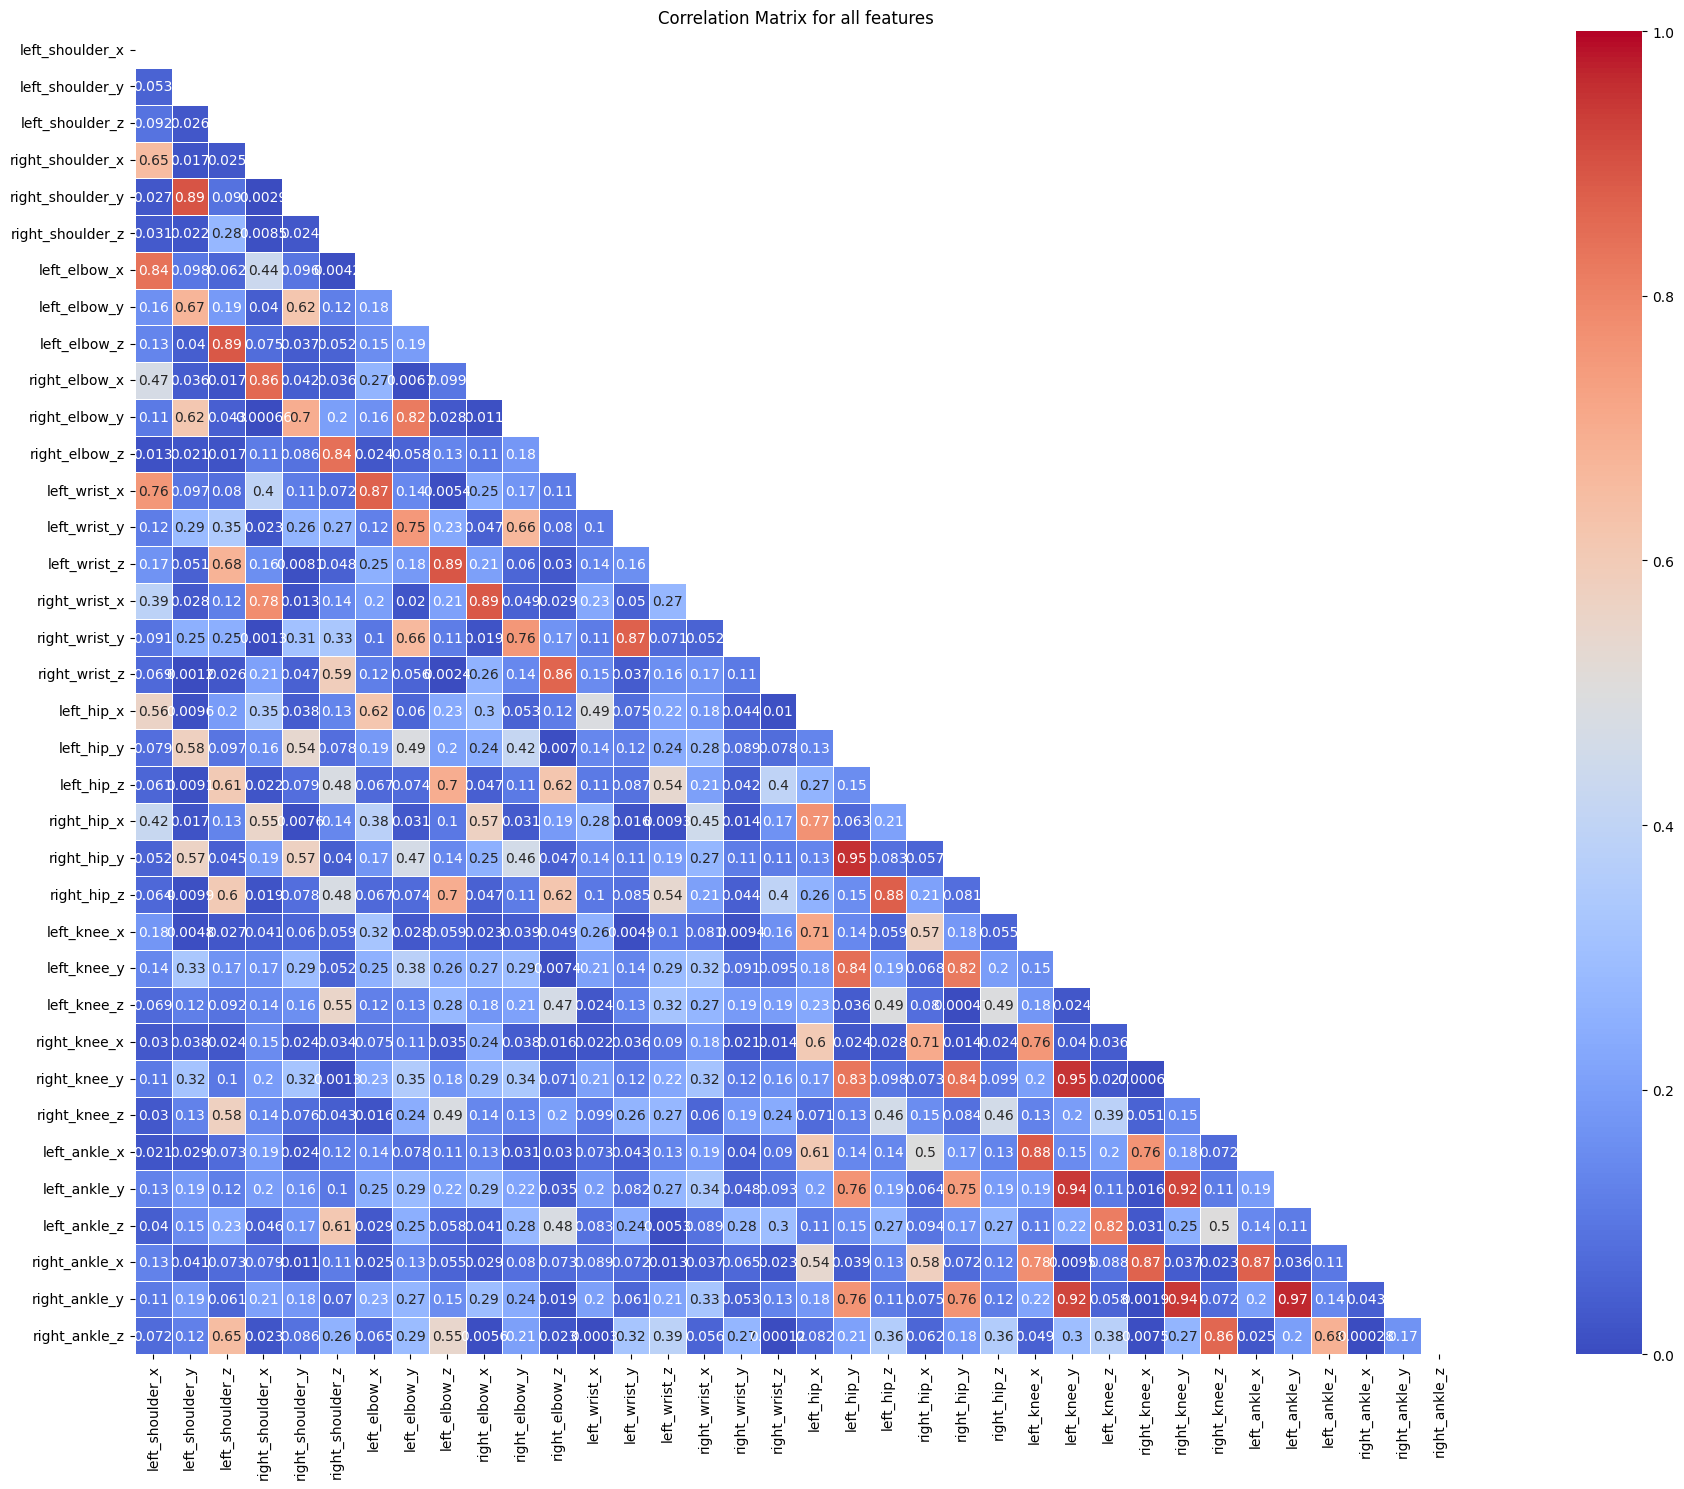

In [113]:
corr_matrix = X_train.corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(24, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', 
            vmax=1.0, vmin=0, center=0.5,
            square=True, linewidths=.5, annot=True).set(title='Correlation Matrix for all features')
plt.tight_layout()
plt.show()

**Features that are highly correlated , one of them should be removed**
- it is better to remove the one that is the least correlated with y_target

In [114]:
correlation_threshold = 0.8
columns_to_drop = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > correlation_threshold:
            columns_to_drop.append(corr_matrix.columns[j])
            print(f"High Correlation between {corr_matrix.columns[i]} and {corr_matrix.columns[j]} --> {corr_matrix.iloc[i, j]:.2f}")

columns_to_drop = list(set(columns_to_drop))
print(f"Columns to drop: {columns_to_drop}")
print(f"number of columns to drop: {len(columns_to_drop)}")

High Correlation between left_shoulder_x and left_elbow_x --> 0.84
High Correlation between left_shoulder_y and right_shoulder_y --> 0.89
High Correlation between left_shoulder_z and left_elbow_z --> 0.89
High Correlation between right_shoulder_x and right_elbow_x --> 0.86
High Correlation between right_shoulder_z and right_elbow_z --> 0.84
High Correlation between left_elbow_x and left_wrist_x --> 0.87
High Correlation between left_elbow_y and right_elbow_y --> 0.82
High Correlation between left_elbow_z and left_wrist_z --> 0.89
High Correlation between right_elbow_x and right_wrist_x --> 0.89
High Correlation between right_elbow_z and right_wrist_z --> 0.86
High Correlation between left_wrist_y and right_wrist_y --> 0.87
High Correlation between left_hip_y and right_hip_y --> 0.95
High Correlation between left_hip_y and left_knee_y --> 0.84
High Correlation between left_hip_y and right_knee_y --> 0.83
High Correlation between left_hip_z and right_hip_z --> 0.88
High Correlation betwe

In [115]:
print(f"Columns to drop: {columns_to_drop}")


Columns to drop: ['left_knee_y', 'left_ankle_y', 'right_elbow_y', 'right_ankle_y', 'right_wrist_y', 'left_ankle_z', 'left_ankle_x', 'left_elbow_x', 'right_hip_y', 'left_wrist_z', 'right_elbow_x', 'right_wrist_z', 'left_wrist_x', 'right_ankle_x', 'right_knee_y', 'right_elbow_z', 'right_hip_z', 'right_ankle_z', 'right_wrist_x', 'right_shoulder_y', 'left_elbow_z']


**53 Columns to drop**

In [116]:
X_train_feature_eng=X_train.drop(columns=columns_to_drop)
X_test_feature_eng=X_test.drop(columns=columns_to_drop)

In [117]:
X_train_feature_eng

,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_z,left_elbow_y,left_wrist_y,left_hip_x,left_hip_y,left_hip_z,right_hip_x,left_knee_x,left_knee_z,right_knee_x,right_knee_z
0,0.581935,0.501124,0.186291,0.568085,-0.391214,0.624433,0.824724,0.434720,0.597652,0.158215,0.412190,0.486811,0.213415,0.531314,-0.205924
1,0.288514,0.346324,0.057971,0.045579,-0.532525,0.552517,0.487185,0.297693,0.734853,0.123313,0.298870,0.355363,0.299227,0.378552,0.045809
2,0.558123,0.605586,-0.318622,0.540337,0.036835,0.394954,0.189929,0.270058,0.679256,-0.004519,0.310165,0.173011,0.213415,0.192133,0.249077
3,0.473248,0.462246,-0.368448,0.394430,0.079933,0.597130,0.578949,0.450911,0.758472,-0.117209,0.393122,0.345413,-0.288902,0.262239,-0.040779
4,0.405353,0.329592,0.225652,0.507144,-0.142675,0.475199,0.546325,0.378568,0.628434,0.130123,0.437582,0.403053,0.142478,0.443398,-0.083510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.497283,0.281915,0.209246,0.485248,-0.240389,0.399502,0.505409,0.601115,0.521563,-0.136989,0.473436,0.476407,0.135539,0.482499,-0.133347
39996,0.556420,0.563635,-0.066716,0.477322,0.215371,0.703155,0.671791,0.511333,0.841586,-0.094079,0.454769,0.448431,-0.276704,0.373738,0.008783
39997,0.383070,0.396222,0.086971,0.377088,-0.354891,0.564350,0.687539,0.314261,0.651892,0.127700,0.310277,0.332883,0.190876,0.343287,-0.077757
39998,0.294978,0.149979,-0.076137,0.168467,-0.072076,0.160000,0.091568,0.273595,0.486750,-0.004391,0.182125,0.320462,-0.502909,0.146919,-0.555104


In [118]:
X_train.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z',
       'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'left_wrist_x', 'left_wrist_y',
       'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z',
       'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y',
       'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z',
       'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x',
       'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y',
       'right_ankle_z'],
      dtype='object')

In [119]:
X_train_feature_eng.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_z', 'left_elbow_y', 'left_wrist_y',
       'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'left_knee_x',
       'left_knee_z', 'right_knee_x', 'right_knee_z'],
      dtype='object')

In [120]:
"""
This function takes both training_dataset
then it will show the result for each one of the models

1-Accuracy
2-Classification Report
3-Confusion Matrix
4-Precision, Recall, F1-Score
5-Time Taken to train
6-Features used to build the model

"""

def train_model(model,param_grid,X_train,y_train,X_test,y_test):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=2,
        scoring='accuracy'
    )
    grid_search.fit(X_train,y_train)
    y_predictions=grid_search.predict(X_test)
    accuracy = accuracy_score(y_test,y_predictions)
    report = classification_report(y_test,y_predictions)
    confusion_matrix_values = confusion_matrix(y_test,y_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues', cbar=True, 
                xticklabels=Workout_labels,
                yticklabels=Workout_labels)

    # Add labels, title, and axis ticks
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')

    # Show the plot
    plt.show()
    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", (accuracy*100),"%")
    print("Classification Report:\n", report)
    return grid_search.best_estimator_

**Random Forest**

In [121]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [20],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['sqrt', 'log2', None]
}



**Random Forest with no feature engineering**

Fitting 3 folds for each of 1 candidates, totalling 3 fits


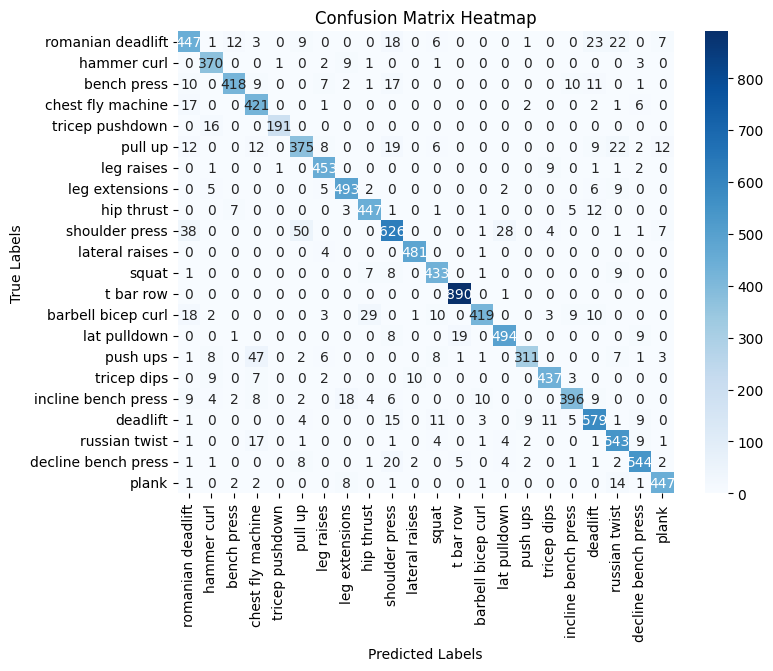

Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Accuracy: 90.5103668261563 %
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81       549
           1       0.89      0.96      0.92       387
           2       0.95      0.86      0.90       486
           3       0.80      0.94      0.86       450
           4       0.99      0.92      0.95       207
           5       0.83      0.79      0.81       477
           6       0.92      0.97      0.94       468
           7       0.92      0.94      0.93       522
           8       0.91      0.94      0.92       477
           9       0.85      0.83      0.84       756
          10       0.97      0.99      0.98       486
          11       0.90      0.94      0.92       459
          12       0.97      1.00      0.99       891
          13       0.95      0.83      0.89       504
          14       0.93      0.93      0.93       531
          15       0.95   

In [122]:
random_tree_model = RandomForestClassifier(random_state=42)
rfc_model = train_model(random_tree_model,param_grid,X_train,y_train,X_test,y_test)
print(rfc_model.classes_)

In [123]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\rfc_workout_classifier.pkl", 'wb') as f:
    print(type(rfc_model))
    pickle.dump(rfc_model, f)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [124]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\rfc_workout_classifier.pkl", 'rb') as f:
    rfc_model = pickle.load(f)

**Random Forest with feature engineering**

Fitting 3 folds for each of 1 candidates, totalling 3 fits


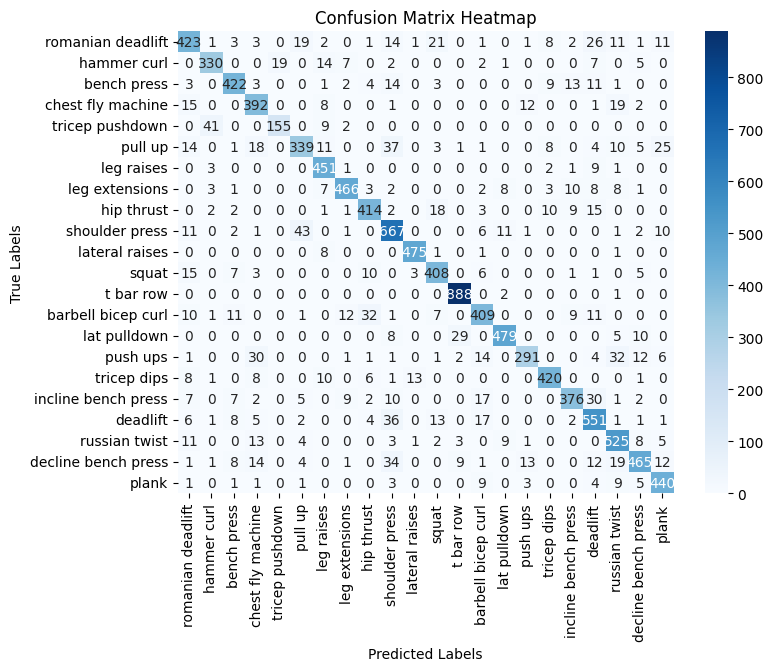

Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Accuracy: 86.70919723551303 %
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.79       549
           1       0.86      0.85      0.86       387
           2       0.89      0.87      0.88       486
           3       0.80      0.87      0.83       450
           4       0.89      0.75      0.81       207
           5       0.81      0.71      0.76       477
           6       0.86      0.96      0.91       468
           7       0.93      0.89      0.91       522
           8       0.87      0.87      0.87       477
           9       0.80      0.88      0.84       756
          10       0.96      0.98      0.97       486
          11       0.86      0.89      0.87       459
          12       0.95      1.00      0.97       891
          13       0.84      0.81      0.82       504
          14       0.94      0.90      0.92       531
          15       0.90  

In [125]:
rfc_feat_eng_model = train_model(random_tree_model,param_grid,X_train_feature_eng,y_train,X_test_feature_eng,y_test)

In [126]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\rfc_feat_eng_workout_classifier.pkl", 'wb') as f:
    print(type(rfc_feat_eng_model))
    pickle.dump(rfc_feat_eng_model, f)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>


In [127]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\rfc_workout_classifier.pkl", 'rb') as f:
    rfc_feat_eng_model = pickle.load(f)

**Multilayer Perceptron**

In [128]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,),],  
    # 'activation': ['relu', 'tanh'],  
    # 'solver': ['adam', 'sgd'],  
    # 'alpha': [0.0001, 0.001, 0.01],  
    # 'learning_rate': ['constant', 'adaptive'],  
    # 'max_iter': [200, 500, 1000]  
}

**Multilayer Perceptron with no feature engineering**

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\y4-sayedtawfee\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


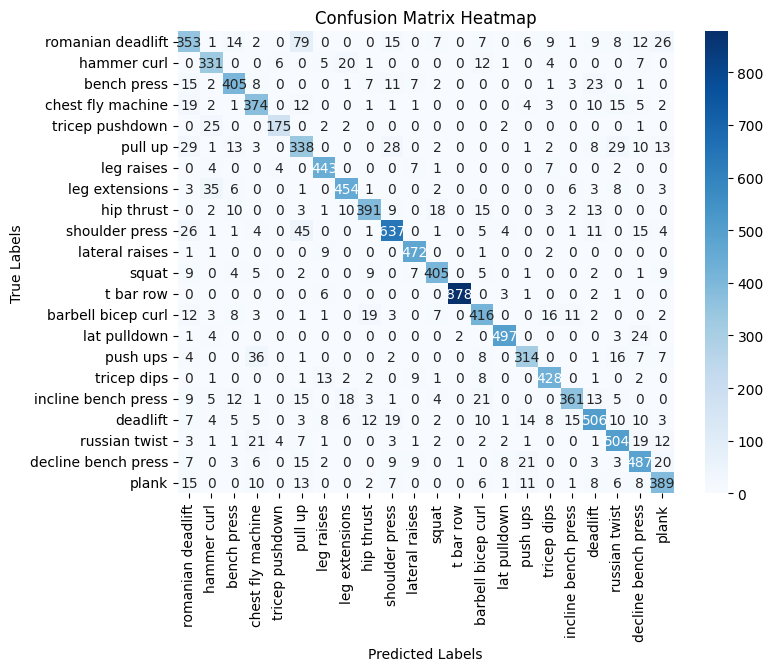

Best Parameters: {'hidden_layer_sizes': (100,)}
Accuracy: 84.688995215311 %
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.64      0.66       549
           1       0.78      0.86      0.82       387
           2       0.84      0.83      0.84       486
           3       0.78      0.83      0.81       450
           4       0.93      0.85      0.88       207
           5       0.63      0.71      0.67       477
           6       0.90      0.95      0.92       468
           7       0.88      0.87      0.88       522
           8       0.87      0.82      0.84       477
           9       0.86      0.84      0.85       756
          10       0.92      0.97      0.94       486
          11       0.89      0.88      0.89       459
          12       1.00      0.99      0.99       891
          13       0.81      0.83      0.82       504
          14       0.96      0.94      0.95       531
          15       0.84      0.79  

In [129]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

mlp_model = train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

In [130]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\mlp_workout_classifier.pkl", 'wb') as f:
    print(type(mlp_model))
    pickle.dump(mlp_model, f)

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


In [131]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\mlp_workout_classifier.pkl", 'rb') as f:
    mlp_model = pickle.load(f)

**Multilayer Perceptron with feature engineering**

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\y4-sayedtawfee\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


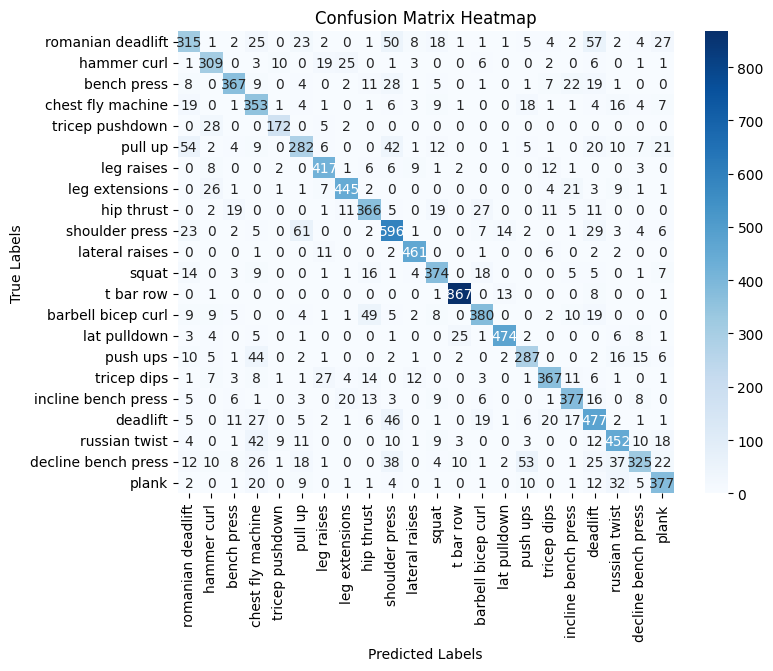

Best Parameters: {'hidden_layer_sizes': (100,)}
Accuracy: 78.3271309587099 %
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.57      0.61       549
           1       0.75      0.80      0.77       387
           2       0.84      0.76      0.80       486
           3       0.60      0.78      0.68       450
           4       0.87      0.83      0.85       207
           5       0.66      0.59      0.62       477
           6       0.83      0.89      0.86       468
           7       0.87      0.85      0.86       522
           8       0.75      0.77      0.76       477
           9       0.70      0.79      0.74       756
          10       0.91      0.95      0.93       486
          11       0.79      0.81      0.80       459
          12       0.95      0.97      0.96       891
          13       0.81      0.75      0.78       504
          14       0.93      0.89      0.91       531
          15       0.73      0.72 

In [132]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

mlp_feat_eng_model = train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

In [133]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\mlp_feat_eng_workout_classifier.pkl", 'wb') as f:
    print(type(mlp_feat_eng_model))
    pickle.dump(mlp_feat_eng_model, f)

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>


In [134]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\mlp_feat_eng_workout_classifier.pkl", 'rb') as f:
    mlp_feat_eng_model = pickle.load(f)

**Support Vector Machines**

In [135]:
param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto'],  
}

In [136]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

svc_model = train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\svc_workout_classifier.pkl", 'wb') as f:
    print(type(svc_model))
    pickle.dump(svc_model, f)

In [ ]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\svc_workout_classifier.pkl", 'rb') as f:
    svc_model = pickle.load(f)

In [ ]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

svc_feat_eng_model = train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

In [ ]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\svc_feat_eng_workout_classifier.pkl", 'wb') as f:
    print(type(svc_feat_eng_model))
    pickle.dump(svc_feat_eng_model, f)

In [ ]:
with open("H:\\DesD_AI_pathway\\AI\\data\\models\\svc_feat_eng_workout_classifier.pkl", 'rb') as f:
    svc_model = pickle.load(f)

**Upsampling the training dataset, then comparing the results to above**
- Applying SMOTE to make sure all classes are evenly distributed